In [1]:
!pip install --upgrade librosa
import matplotlib.pyplot as plt
import librosa 
import librosa.display
import IPython.display as ipd 
import numpy as np
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import torchaudio
import os
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import torchaudio
from torch.optim import Adam
from torch.autograd import Variable


In [2]:
class MonoToColor(nn.Module):
    def __init__(self, num_channels=3):
        super(MonoToColor, self).__init__()
        self.num_channels = num_channels

    def forward(self, tensor):
        return tensor.repeat(self.num_channels, 1, 1)

In [3]:
import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Cuda torch working : True
current device no. : 0
GPU device count : 2
GPU name : Tesla T4
device :  cuda
nvidia-smi output:
Thu Oct 12 11:33:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |    532MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+-----------

In [4]:
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        self.annotations = (annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_sample_rate:
            signal = signal[:, :self.target_sample_rate]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_sample_rate:
            num_missing_samples = self.target_sample_rate - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        file_name = self.annotations.iloc[index, 0]
        audio_sample_path = os.path.join(self.audio_dir, fold, file_name)
        return audio_sample_path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [5]:
ANNOTATIONS_FILE = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
AUDIO_DIR = "/kaggle/input/urbansound8k"

In [6]:
ANNOTATIONS_FILE

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [7]:
dog_bark_file="/kaggle/input/urbansound8k/fold5/100032-3-0-0.wav"
dog_bark,_=librosa.load(dog_bark_file)

child_play_file="/kaggle/input/urbansound8k/fold5/100263-2-0-117.wav"
child_play,_=librosa.load(child_play_file)

Street_music_file="/kaggle/input/urbansound8k/fold7/101848-9-0-0.wav"
Street_music,_=librosa.load(Street_music_file)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
ipd.Audio(dog_bark_file)

In [9]:
ipd.Audio(child_play_file)

In [10]:
ipd.Audio(Street_music_file)

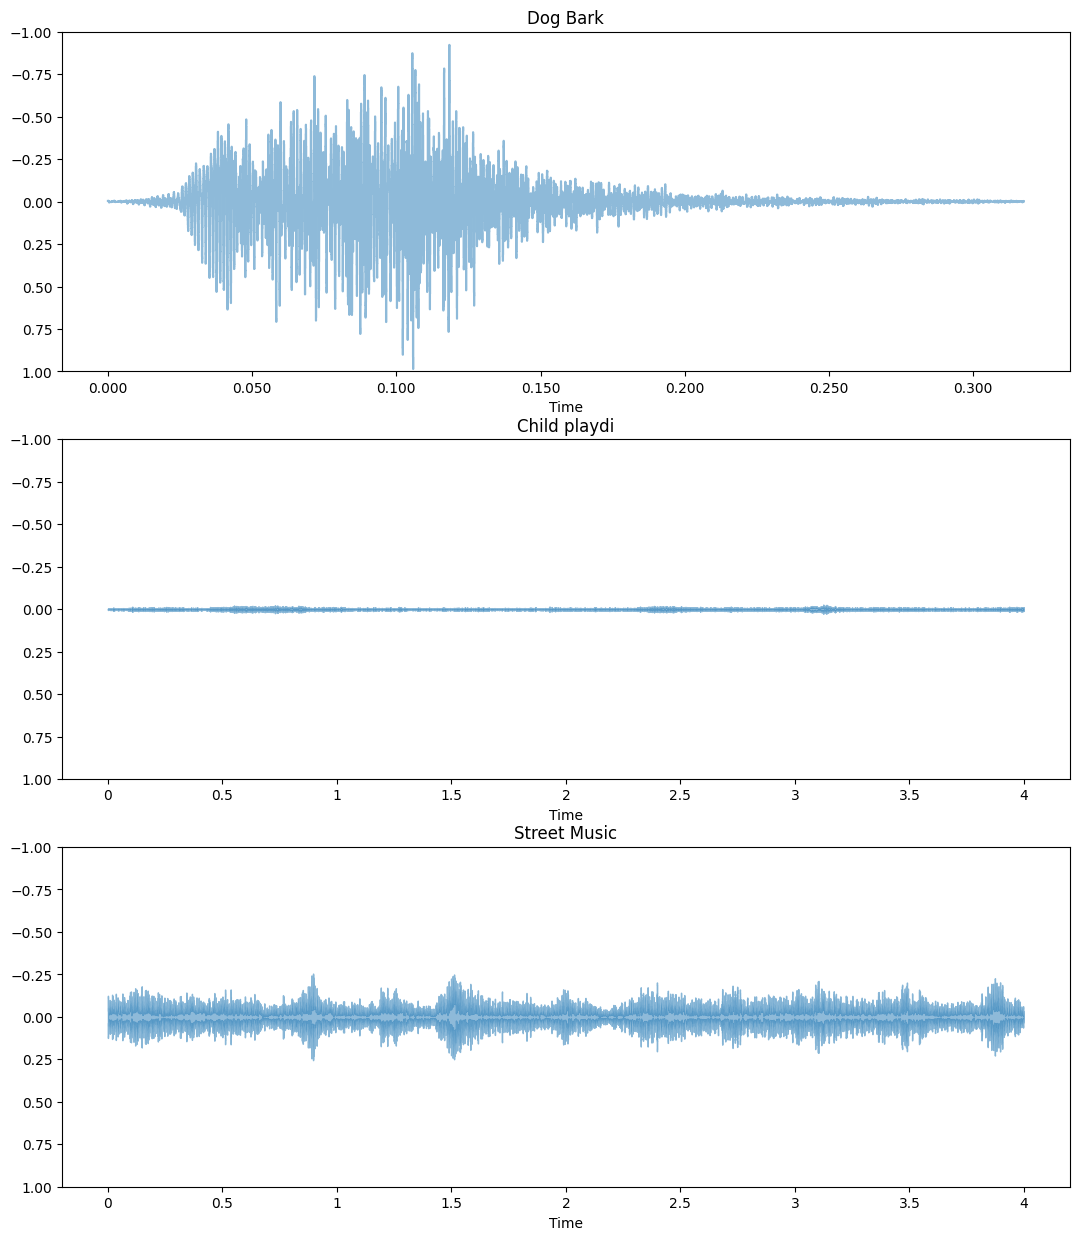

In [11]:
plt.figure(figsize=(13,15))
plt.subplot(3,1,1)
librosa.display.waveshow(dog_bark,alpha=0.5)
plt.title("Dog Bark")
plt.ylim(1,-1)

plt.subplot(3,1,2)
librosa.display.waveshow(child_play,alpha=0.5)
plt.title("Child playdi")
plt.ylim(1,-1)

plt.subplot(3,1,3)
librosa.display.waveshow(Street_music,alpha=0.5)
plt.title("Street Music")
plt.ylim(1,-1)

plt.show()

In [12]:


SAMPLE_RATE = 22050
BATCH_SIZE = 64
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

transformation = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=128),
    torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80),
    MonoToColor(),
])
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE)

dataset_size = len(usd)
train_size = int(0.7 * dataset_size)
test_size = int(dataset_size - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(usd, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [13]:
from torchvision import models
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Let's use 2 GPUs!


In [14]:
optimiser=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=35
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=7, gamma=0.1)

In [15]:
from tqdm import tqdm
best_accuracy=0.0

for epoch in range (num_epochs):
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for inputs, labels in tqdm(train_loader):
        if torch.cuda.is_available():
            inputs=Variable(inputs.to(device))
            labels=Variable(labels.to(device))
            
        optimiser.zero_grad()
        outputs=model(inputs)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        
        train_loss+=loss.cpu().data*inputs.size(0)
        _, prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
    
    scheduler.step()
    
    train_accuracy=train_accuracy/len(train_loader.dataset)
    
    train_loss=train_loss/len(train_loader.dataset)
    
    
    model.eval()
    test_accuracy=0.0
    total_predictions=0
    for inputs, labels in tqdm(test_loader):
        if torch.cuda.is_available():
            inputs=Variable(inputs.to(device))
            labels=Variable(labels.to(device))
            
            
        outputs=model(inputs)
        _, prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        total_predictions += labels.size(0)
        
    test_accuracy=test_accuracy/total_predictions
    
    if epoch%10==0:
        print('Epoch: '+str(epoch)+' Train loss: '+str(train_loss)+' Train accuracy '+str(train_accuracy)+' Test accuracy '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'ResNet.model')
        best_accuracy=test_accuracy

100%|██████████| 41/41 [01:39<00:00,  2.43s/it]


Epoch: 0 Train loss: tensor(1.3982) Train accuracy 0.5032722513089005 Test accuracy 0.5767175572519084


100%|██████████| 41/41 [00:31<00:00,  1.31it/s]


Epoch: 10 Train loss: tensor(0.0686) Train accuracy 0.9797120418848168 Test accuracy 0.9114503816793893


100%|██████████| 41/41 [00:35<00:00,  1.14it/s]


Epoch: 20 Train loss: tensor(0.0184) Train accuracy 0.9973821989528796 Test accuracy 0.9152671755725191


100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


Epoch: 30 Train loss: tensor(0.0202) Train accuracy 0.9959096858638743 Test accuracy 0.9194656488549618


100%|██████████| 41/41 [00:36<00:00,  1.12it/s]


In [16]:
print(best_accuracy)

0.9198473282442748
